In [0]:
#######################################################################
# Authors:
# Nathan Margaglio (nathanmargaglio@gmail.com)                                                          
# Mihir Hemant Chauhan (mihirhem@buffalo.edu)                       
# Qian Cheng (qcheng2@buffalo.edu)                            
#######################################################################
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

In [0]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

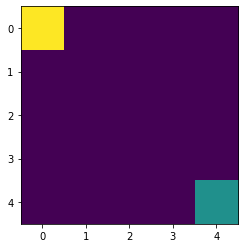

In [3]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [0]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

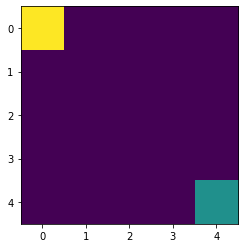

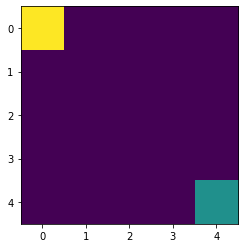

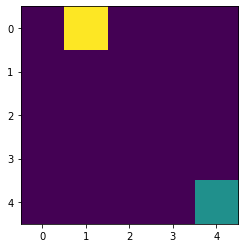

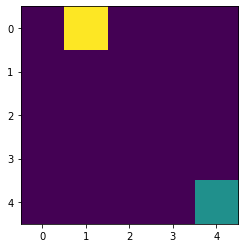

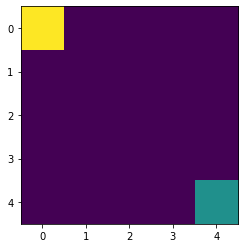

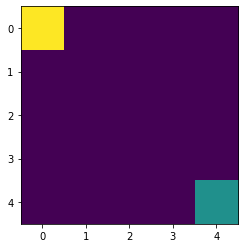

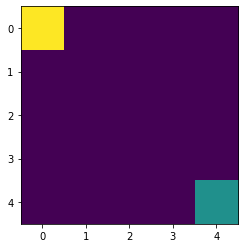

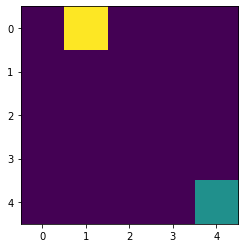

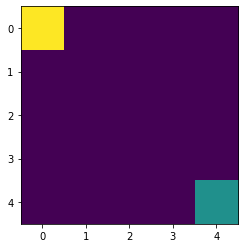

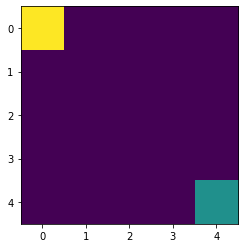

In [5]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [0]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

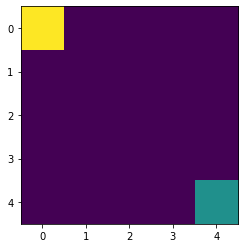

[0. 0.]


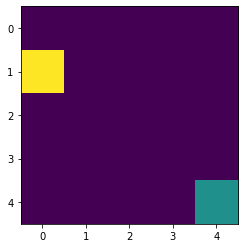

[0.25 0.  ]


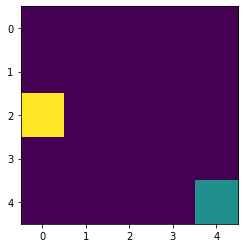

[0.5 0. ]


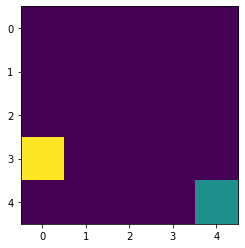

[0.75 0.  ]


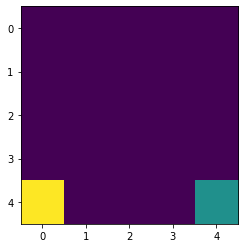

[1. 0.]


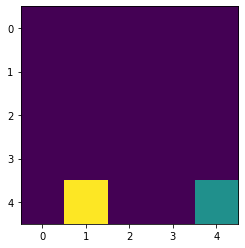

[1.   0.25]


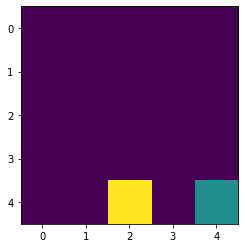

[1.  0.5]


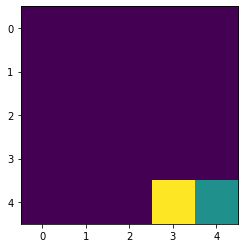

[1.   0.75]


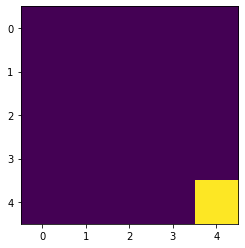

In [7]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [0]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)      
      observation = observation.astype(int)
      if np.random.random() <= self.epsilon:
          return self.env.action_space.sample()
      else:
          return np.argmax(self.q_table[tuple(observation)])
       
       
        
    def step(self, observation):
      return self.policy(observation)
        
    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        self.q_table[state[0]][state[1]][action] = (1 -self.lr)*self.q_table[state[0]][state[1]][action] + self.lr *(reward + self.gamma*np.max(self.q_table[next_state[0]][next_state[1]][action]))
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [0]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 1000 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes

total_rewards = []
epsilons = [agent.epsilon]

# Training Process (Task 3) (20 points)
max_steps_per_episode = 100
for episode in range(episodes):
  state = env.reset()
  done = False
  rewards_current_episode = 0
  min_epsilon = 0
  max_epsilon = 1
  #for step in range(max_steps_per_episode): 
  while not done:
    # threshold = np.random.uniform(0,1)
    action = agent.policy(state)
    obs, reward, done, info = env.step(action)
    agent.update(state,action,reward,obs)
    state = obs.copy()
    rewards_current_episode += reward
    epsilon = min_epsilon +(max_epsilon - min_epsilon)*np.exp(-delta_epsilon*episode)
    agent.set_epsilon(epsilon) #
    epsilons.append(agent.epsilon) #doubt
    


  total_rewards.append(rewards_current_episode)    
  

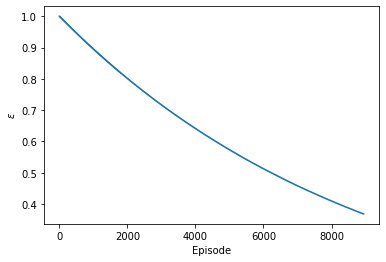

In [17]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

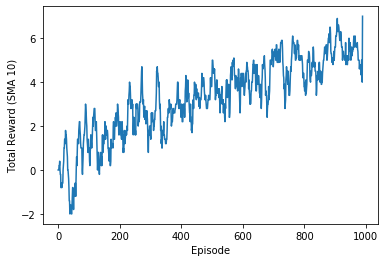

In [18]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

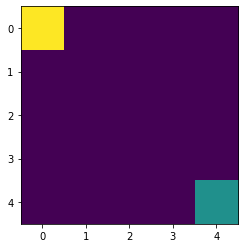

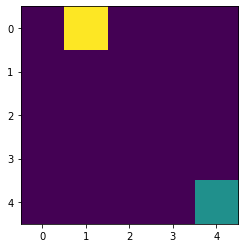

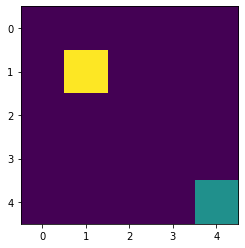

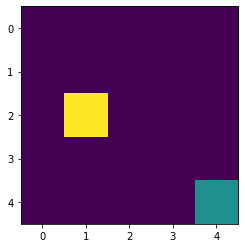

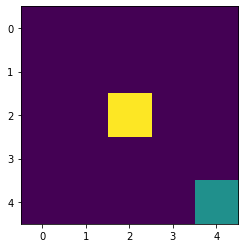

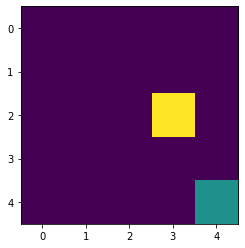

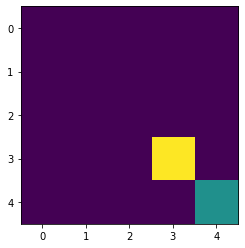

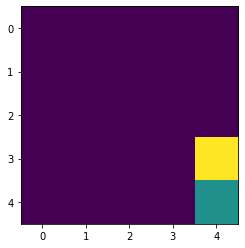

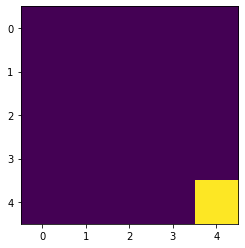

In [19]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [20]:
agent.q_table

array([[[ 3.0410248 , -9.5193502 ,  3.16405265, -9.45774142],
        [ 3.04759119, -8.75122188,  2.40518606, -9.48492592],
        [ 3.1404406 , -4.41733861,  1.5659052 , -9.05618089],
        [ 2.65425352, -1.22478977,  0.6477682 , -4.7632226 ],
        [ 1.35043255, -0.4900995 , -0.3940399 , -0.47381241]],

       [[ 2.26690018, -9.42965757,  3.04105978, -7.52661314],
        [ 2.27437506, -8.73009   ,  2.26478504, -7.68362904],
        [ 2.33548645, -4.78741226,  1.39844606, -7.74786836],
        [ 1.87924129, -1.83771493,  0.4051715 , -6.11630765],
        [ 1.36412004, -0.78654981, -0.77255306, -1.6278349 ]],

       [[ 1.39563775, -8.27240015,  3.08265952, -2.82269467],
        [ 1.41457119, -8.54188405,  2.38857771, -3.36586575],
        [ 1.45932904, -5.21612553,  1.55185003, -3.88307179],
        [ 0.63031548, -2.24090458,  0.62262459, -3.47813969],
        [ 1.64299221, -0.56018818, -0.3940399 , -1.48189362]],

       [[ 0.37172743, -3.94825503,  2.42286104, -1.73831376],
  